<a href="https://colab.research.google.com/github/AloraTab/aat2000/blob/main/dissy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
%pip install pandas==1.5.3
%pip install tensorflow-addons==0.19.0
%pip install tensorflow==2.11.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 52.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 106.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 87.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 73.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 106.0 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-

In [ ]:
from tensorflow import keras
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D
from keras.layers import Attention
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.optimizers.schedules import ExponentialDecay, CosineDecayRestarts
from keras.callbacks import Callback
from keras import backend as K

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math

## Imported Classes

In [ ]:
# Cosine Annealing Scheduler
# https://github.com/4uiiurz1/keras-cosine-annealing/blob/master/cosine_annealing.py

class CosineAnnealingScheduler(Callback):
    """Cosine annealing scheduler.
    """

    def __init__(self, T_max, eta_max, eta_min=0, verbose=0):
        super(CosineAnnealingScheduler, self).__init__()
        self.T_max = T_max
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = self.eta_min + (self.eta_max - self.eta_min) * (1 + math.cos(math.pi * epoch / self.T_max)) / 2
        K.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nEpoch %05d: CosineAnnealingScheduler setting learning '
                  'rate to %s.' % (epoch + 1, lr))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

In [ ]:
# LR Finder in Keras
# https://github.com/avanwyk/tensorflow-projects/tree/master/lr-finder

class LRFinder(Callback):
    """`Callback` that exponentially adjusts the learning rate after each training batch between `start_lr` and
    `end_lr` for a maximum number of batches: `max_step`. The loss and learning rate are recorded at each step allowing
    visually finding a good learning rate as per https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html via
    the `plot` method.
    """

    def __init__(self, start_lr: float = 1e-7, end_lr: float = 10, max_steps: int = 100, smoothing=0.9):
        super(LRFinder, self).__init__()
        self.start_lr, self.end_lr = start_lr, end_lr
        self.max_steps = max_steps
        self.smoothing = smoothing
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_begin(self, logs=None):
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_batch_begin(self, batch, logs=None):
        self.lr = self.exp_annealing(self.step)
        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        step = self.step
        if loss:
            self.avg_loss = self.smoothing * self.avg_loss + (1 - self.smoothing) * loss
            smooth_loss = self.avg_loss / (1 - self.smoothing ** (self.step + 1))
            self.losses.append(smooth_loss)
            self.lrs.append(self.lr)

            if step == 0 or loss < self.best_loss:
                self.best_loss = loss

            if smooth_loss > 4 * self.best_loss or tf.math.is_nan(smooth_loss):
                self.model.stop_training = True

        if step == self.max_steps:
            self.model.stop_training = True

        self.step += 1

    def exp_annealing(self, step):
        return self.start_lr * (self.end_lr / self.start_lr) ** (step * 1. / self.max_steps)

    def plot(self):
        fig, ax = plt.subplots(1, 1)
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate (log scale)')
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
        ax.plot(self.lrs, self.losses)

In [ ]:
#https://github.com/nathanhubens/KerasOneCycle
from keras.callbacks import Callback
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

#####################
##### OneCycle  #####
#####################

          
class OneCycle(Callback):
    """This callback implements a cyclical learning rate and momentum policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration 
    For more detail, please see paper.
    
    # Example
        ```python
            clr = OneCycle(min_lr=1e-3, max_lr=1e-2,
                      min_mtm=0.85, max_mtm=0.95,
                      annealing=0.1,step_size=np.ceil((X_train.shape[0]*epochs/batch_size)))
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    # Arguments
        min_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - min_lr).
        step_size: number of training iterations in the cycle. To define as `np.ceil((X_train.shape[0]*epochs/batch_size))`
        max_mtm : initial value of the momentum    
        min_mtm : lower boundary in the cycle.
        annealing_stage : percentage of the iterations where the lr
                    will decrease lower than its min_lr
        annealing_rate : in annealing phase learning rate will be decreased to annealing_rate*min_lr
                    
        # References
        Original paper: https://arxiv.org/pdf/1803.09820.pdf
        Inspired by : https://sgugger.github.io/the-1cycle-policy.html#the-1cycle-policy
    """

    def __init__(self, min_lr=1e-5, max_lr=1e-2, min_mtm = 0.85, max_mtm=0.95, training_iterations=1000.,
                 annealing_stage=0.1, annealing_rate=0.01):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.min_mtm = min_mtm
        self.max_mtm = max_mtm
        self.annealing_stage = annealing_stage
        self.step_size = training_iterations*(1-self.annealing_stage)/2
        self.min_annealing_lr = annealing_rate * min_lr
        self.iterations = 0.
        self.training_iterations = training_iterations
        self.history = {}
        
    def clr(self):
        if self.iterations < 2*self.step_size :
            x = np.abs(self.iterations/self.step_size - 1)
            return self.min_lr + (self.max_lr-self.min_lr)*(1-x)
        else:
            x = min(1, float(self.iterations - 2 * self.step_size) / (self.training_iterations - 2 * self.step_size))
            return self.min_lr - (self.min_lr - self.min_annealing_lr) * x
        
    
    def cmtm(self):
        if self.iterations < 2*self.step_size :   
            x = np.abs(self.iterations/self.step_size - 1)
        else: 
            x=1
        return self.min_mtm + (self.max_mtm-self.min_mtm)*(x)     
        
    def on_train_begin(self, logs={}):
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.min_lr)
        K.set_value(self.model.optimizer.momentum, self.max_mtm)
         
    def on_batch_end(self, batch, logs=None):
        
        logs = logs or {}
        self.iterations += 1
    
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('momentum', []).append(K.get_value(self.model.optimizer.momentum))
        self.history.setdefault('iterations', []).append(self.iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr()) 
        K.set_value(self.model.optimizer.momentum, self.cmtm())
        
    def plot_lr(self):
        plt.xlabel('Training Iterations')
        plt.ylabel('Learning Rate')
        plt.title("CLR - '1 cycle' Policy")
        plt.plot(self.history['iterations'], self.history['lr'])
        
    def plot_mtm(self):
        plt.xlabel('Training Iterations')
        plt.ylabel('Momentum')
        plt.title("CLR - '1 cycle' Policy")
        plt.plot(self.history['iterations'], self.history['momentum'])

# Preparing Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
PATH = '/content/gdrive/MyDrive/Colab Notebooks/Dataset'
fileName = 'csi-dataset-29-7-5-more.pkl'
fullPath = os.path.join(PATH, fileName)
print(fullPath)

/content/gdrive/MyDrive/Colab Notebooks/Dataset/csi-dataset-29-7-5-more.pkl


In [ ]:
df = pd.read_pickle(fullPath)

In [ ]:
# df = df.sample(frac=1)
Y = df['Label'].values
X = df['Sample'].values
X = [[np.asarray(sample) for sample in i] for i in X]
X = np.asarray(X).astype('float32')

In [ ]:
X.shape

(10627, 256, 180)

In [ ]:
# unique, counts = np.unique(Y_test, return_counts=True)
# print(np.asarray((unique, counts)).T)

In [ ]:
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
vectorized_y = np_utils.to_categorical(encoded_Y)

In [ ]:
classes = encoder.classes_
print(classes)

['I1' 'I11' 'I13' 'I3' 'I5' 'I7' 'I9']


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,vectorized_y, test_size=0.3, random_state=40)

In [ ]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],X_train.shape[2],1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],X_test.shape[2],1))

X_train = tf.convert_to_tensor(X_train)
Y_train = tf.convert_to_tensor(Y_train)

# Building Model

### Custom Components

In [ ]:
# Residual Connections using code from below as well as the residual connections from XCeption
# https://stackoverflow.com/questions/64792460/how-to-code-a-residual-block-using-two-layers-of-a-basic-cnn-algorithm-built-wit

def resblock(x, kernelsize, filters):
    fx = keras.layers.Conv2D(filters, kernelsize, activation='relu', padding='same')(x)
    fx = keras.layers.BatchNormalization()(fx)
    fx = keras.layers.Conv2D(filters, kernelsize, padding='same')(fx)
    out = keras.layers.Add()([x,fx])
    out = keras.layers.ReLU()(out)
    out = keras.layers.BatchNormalization()(out)
    return out

In [ ]:
# Mish Activation
def mish(inputs):
    x = tf.nn.softplus(inputs)
    x = tf.nn.tanh(x)
    x = tf.multiply(x,inputs)
    return x

In [ ]:
# Ranger Optimizer
# www.kaggle.com/code/yazanmajzob/ranger-optimizeranvas.com

import tensorflow_addons as tfa

def Ranger(sync_period=6,
           slow_step_size=0.5,
           learning_rate=0.001,
           beta_1=0.9,
           beta_2=0.999,
           epsilon=1e-7,
           weight_decay=0.,
           amsgrad=False,
           sma_threshold=5.0,
           total_steps=0,
           warmup_proportion=0.1,
           min_lr=0.,
           name="Ranger"):
    inner = tfa.optimizers.RectifiedAdam(learning_rate, beta_1, beta_2, epsilon, weight_decay, amsgrad, sma_threshold, total_steps, warmup_proportion, min_lr, name)
    optim = tfa.optimizers.Lookahead(inner, sync_period, slow_step_size, name)
    return optim

### Model Building

In [ ]:
def basecsiTime_block(input_layer):
    layer_1 = Conv2D(16, (10,10), padding='same', activation='relu')(input_layer)

    layer_2 = Conv2D(16, (20,20), padding='same', activation='relu')(input_layer)

    layer_3 = Conv2D(16, (40,40), padding='same', activation='relu')(input_layer)

    layer_4 = keras.layers.MaxPooling2D(pool_size=(1,1))(input_layer)
    layer_5 = keras.layers.concatenate([layer_1, layer_2, layer_3, layer_4])

    layer_6 = keras.layers.BatchNormalization()(layer_5)
    output_layer = keras.layers.Dense(7, activation=mish)(layer_6)
    
    return output_layer

def csiTime_selfattn(input_layer):
    layer_1 = Conv2D(16, (10,10), padding='same', activation='relu')(input_layer)
    layer_2 = Conv2D(16, (20,20), padding='same', activation='relu')(input_layer)
    layer_3 = Conv2D(16, (40,40), padding='same', activation='relu')(input_layer)

    layer_4 = keras.layers.MaxPooling2D(pool_size=(1,1))(input_layer)
    layer_5 = keras.layers.concatenate([layer_1, layer_2, layer_3, layer_4])

    layer_6 = keras.layers.BatchNormalization()(layer_5)
    layer_7 = keras.layers.Attention(use_scale=True)([layer_6, layer_6])
    output_layer = keras.layers.Dense(7, activation=mish)(layer_7)
    
    return output_layer

def csimini_selfattn(input_layer):
    
    layer_1 = keras.layers.Attention(use_scale=True)([input_layer, input_layer])
    layer_2 = Conv2D(16, (3,3), padding='same', activation='relu')(layer_1)
    layer_3 = keras.layers.BatchNormalization()(layer_2)
    output_layer = keras.layers.MaxPooling2D(pool_size=(1,1))(layer_3)
    output_layer = keras.layers.Dense(7, activation=mish)(output_layer)

    return output_layer

def csi_mini(input_layer):
    
    layer_1 = SeparableConv2D(10, (3,3), padding='same', activation='relu')(input_layer)
    bn1 = keras.layers.BatchNormalization()(layer_1)
    layer_2 = SeparableConv2D(20, (3,3), padding='same', activation='relu')(input_layer)
    bn2 = keras.layers.BatchNormalization()(layer_2)
    layer_3 = SeparableConv2D(40, (3,3), padding='same', activation='relu')(input_layer)
    bn3 = keras.layers.BatchNormalization()(layer_3)

    layer_4 = keras.layers.MaxPooling2D(pool_size=(1,1))(input_layer)
    con = Conv2D(16, (3,3), padding='same', activation='relu')(layer_4)
    layer_5 = keras.layers.concatenate([bn1, bn2, bn3, con])

    layer_6 = keras.layers.BatchNormalization()(layer_5)
    output_layer = keras.layers.Dense(7, activation=mish)(layer_6)
    
    return output_layer

In [ ]:
from tensorflow.python.ops.nn_ops import softmax

def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape, dtype='float32')

    # fir = basecsiTime_block(input_layer)
    # sec = basecsiTime_block(fir)
    # res1 = resblock(sec, (3,3), 7)
    # thi = csiTime_selfattn(res1)
    # fou = basecsiTime_block(thi)
    # fif = csiTime_selfattn(fou)
    # res2 = resblock(fif, (3,3), 7)
    # six = basecsiTime_block(res2)

    x = csi_mini(input_layer)
    x = resblock(x, (3,3), 7)
    x = csimini_selfattn(x)
    x = basecsiTime_block(x)
    x = csimini_selfattn(x)
    x = resblock(x, (3,3), 7)
    x = csi_mini(x)
    
    gap = keras.layers.GlobalAveragePooling2D()(x)
    flatten = keras.layers.Flatten()(gap)
    dropout = keras.layers.Dropout(.2)(flatten)
    output_layer = keras.layers.Dense(7, activation=softmax)(dropout)
    
    return keras.models.Model(inputs=input_layer, outputs=output_layer)

model = make_model(input_shape=X_train.shape[1:])
# keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 180, 1  0           []                               
                                )]                                                                
                                                                                                  
 separable_conv2d_9 (SeparableC  (None, 256, 180, 10  29         ['input_2[0][0]']                
 onv2D)                         )                                                                 
                                                                                                  
 separable_conv2d_10 (Separable  (None, 256, 180, 20  49         ['input_2[0][0]']                
 Conv2D)                        )                                                           

In [ ]:
epochs = 60
batch_size = 96
# steps_per_epoch = X_train.shape[0]

# lr_schedule = ExponentialDecay(
#     initial_learning_rate=0.001,
#     decay_steps=1000, decay_rate=0.96,
#     staircase=True)

# lr_schedule = OneCycle(min_lr=7e-3, max_lr=7e-2, min_mtm = 0.85, max_mtm = 0.95, annealing_stage=0.1, annealing_rate=0.01,
#           training_iterations=(X_train.shape[0]*epochs)/(batch_size))
lr_schedule = CosineDecayRestarts(initial_learning_rate=0.001,first_decay_steps=1000)

# clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=0.0001,
#     maximal_learning_rate=0.01,
#     scale_fn=lambda x: 1/(2.**(x-1)),
#     step_size=2 * steps_per_epoch
# )
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "mini7.h5", save_best_only=True, monitor="val_loss"
    ),
    # OneCycle(min_lr=7e-3, max_lr=7e-2, min_mtm = 0.85, max_mtm = 0.95, annealing_stage=0.1, annealing_rate=0.01,
    #       training_iterations=(X_train.shape[0]*epochs)/(batch_size)),
    # keras.callbacks.ReduceLROnPlateau(
    #     monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    # ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, verbose=1),
]
model.compile(
    # optimizer=Ranger(learning_rate = lr_schedule),
    optimizer = keras.optimizers.Adam(learning_rate=lr_schedule, epsilon=1e-08),
    loss="categorical_crossentropy",
    metrics=["categorical_accuracy"],
)
history = model.fit(
    X_train,
    Y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
    
)

Epoch 1/60
62/62 [==============================] - 377s 4s/step - loss: 1.9188 - categorical_accuracy: 0.1993 - val_loss: 1.9424 - val_categorical_accuracy: 0.2070
Epoch 2/60
62/62 [==============================] - 68s 1s/step - loss: 1.7635 - categorical_accuracy: 0.2861 - val_loss: 1.8887 - val_categorical_accuracy: 0.2184
Epoch 3/60
62/62 [==============================] - 68s 1s/step - loss: 1.6130 - categorical_accuracy: 0.3432 - val_loss: 1.8479 - val_categorical_accuracy: 0.2345
Epoch 4/60
62/62 [==============================] - 68s 1s/step - loss: 1.5227 - categorical_accuracy: 0.3672 - val_loss: 2.4015 - val_categorical_accuracy: 0.1358
Epoch 5/60
62/62 [==============================] - 68s 1s/step - loss: 1.4503 - categorical_accuracy: 0.3892 - val_loss: 1.9116 - val_categorical_accuracy: 0.2298
Epoch 6/60
62/62 [==============================] - 68s 1s/step - loss: 1.4049 - categorical_accuracy: 0.4076 - val_loss: 2.0379 - val_categorical_accuracy: 0.2413
Epoch 7/60
62/6

# Evaluation

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,vectorized_y, test_size=0.3, random_state=40)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],X_train.shape[2],1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],X_test.shape[2],1))

X_train = tf.convert_to_tensor(X_train)
Y_train = tf.convert_to_tensor(Y_train)

In [ ]:
# model = keras.models.load_model("sa-mish-adam-150.h5")

test_loss, test_acc = model.evaluate(X_test[:,:,:], Y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

100/100 [==============================] - 10s 88ms/step - loss: 1.0594 - categorical_accuracy: 0.6253
Test accuracy 0.6252743601799011
Test loss 1.0594147443771362


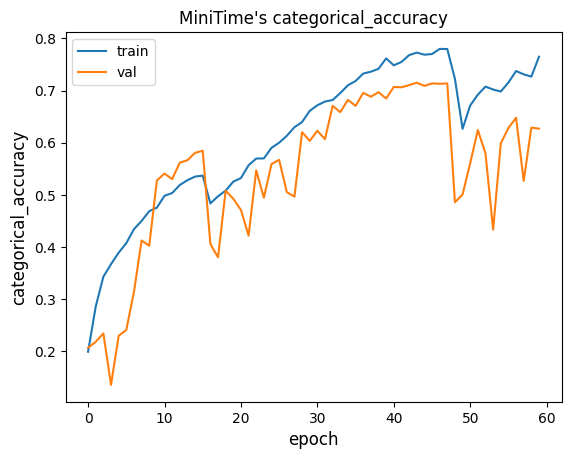

In [ ]:
metric = "categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("MiniTime's " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [ ]:
#Confusion Matrix and Classification Report

y_pred=model.predict(X_test) 
y_pred=np.argmax(y_pred, axis=1)
Y_test=np.argmax(Y_test, axis=1)


100/100 [==============================] - 8s 78ms/step


In [ ]:

cm = confusion_matrix(Y_test, y_pred)
print(cm)

print('Classification Report')
print(classification_report(Y_test, y_pred, target_names=classes))



[[216  87  34  40  22  25  12]
 [  2 154   8   5  65  84  14]
 [  1   0 560  10  11   1 106]
 [  2   0  29 254   3  29 155]
 [  1  47  24   2 154  98  17]
 [  0  33   9   7  57 213  31]
 [  0   0  92   5   6  21 443]]
Classification Report
              precision    recall  f1-score   support

          I1       0.97      0.50      0.66       436
         I11       0.48      0.46      0.47       332
         I13       0.74      0.81      0.78       689
          I3       0.79      0.54      0.64       472
          I5       0.48      0.45      0.47       343
          I7       0.45      0.61      0.52       350
          I9       0.57      0.78      0.66       567

    accuracy                           0.63      3189
   macro avg       0.64      0.59      0.60      3189
weighted avg       0.66      0.63      0.63      3189



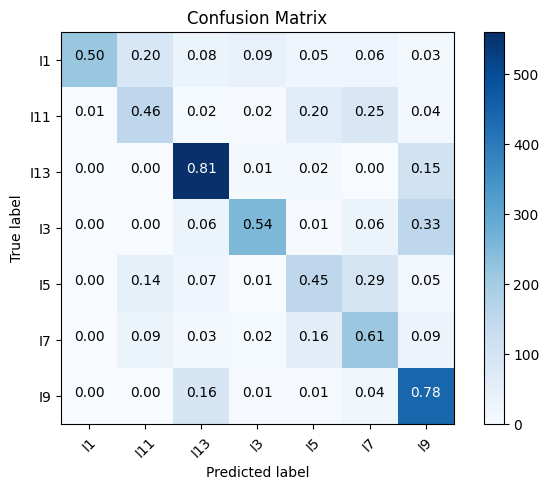

In [ ]:
class_names = ['I1', 'I11', 'I13', 'I3', 'I5', 'I7', 'I9']

cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm_percent[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
%%time 

model.predict(X_test[:10])

1/1 [==============================] - 0s 469ms/step
CPU times: user 511 ms, sys: 4.15 ms, total: 515 ms
Wall time: 518 ms


array([[4.5197932e-03, 9.7349065e-04, 8.7710440e-01, 3.8048804e-03,
        9.7664874e-03, 2.0886727e-03, 1.0174222e-01],
       [2.5290603e-02, 3.5105009e-02, 3.7551302e-01, 5.4106176e-02,
        9.6075095e-02, 9.4528079e-02, 3.1938198e-01],
       [6.2656486e-03, 3.2039499e-03, 7.8095180e-01, 1.9277584e-02,
        1.3159824e-02, 1.0103829e-02, 1.6703725e-01],
       [4.2721780e-04, 4.3074602e-01, 6.0343093e-15, 3.1907166e-06,
        2.0911558e-01, 3.5970616e-01, 1.8956364e-06],
       [5.4594232e-03, 4.0539503e-03, 6.6241723e-01, 4.5795556e-02,
        1.1536901e-02, 2.0347364e-02, 2.5038961e-01],
       [6.4858957e-04, 3.1725486e-04, 4.2921069e-01, 5.0870646e-02,
        1.3351402e-03, 7.6910979e-03, 5.0992662e-01],
       [9.2495074e-03, 5.9087677e-03, 7.0198780e-01, 2.9339701e-02,
        2.1019243e-02, 1.8702485e-02, 2.1379259e-01],
       [2.2557598e-04, 1.6178713e-04, 2.6790923e-01, 4.1023009e-02,
        8.0559339e-04, 7.9958029e-03, 6.8187892e-01],
       [2.4046360e-01, 8

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5242699475072754022
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 40179924992
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7795272470019625299
 physical_device_desc: "device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0"
 xla_global_id: 416903419]